Import IDC images from local drive

In [1]:
#Import relevant packages
import kaggle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob
from skimage.io import imread
from PIL import Image
import fnmatch
import cv2
import shutil
from tensorflow.keras.preprocessing import image

In [2]:
#Import data from local drive
files = os.listdir('C:/Users/benja/Dropbox/Ben Code/Springboard not GIT linked/IDC_image_data/breast-histopathology-images')
print(len(files))
base_path = 'C:/Users/benja/Dropbox/Ben Code/Springboard not GIT linked/IDC_image_data/breast-histopathology-images/IDC_regular_ps50_idx5/'
folder = os.listdir(base_path)

280


We have 280 folders, the releventdata all seems to be held in the IDC_regular_ps50_idx5 folder, so I've made that the base_path for easy reference. Next lets pull patient ID into a workable object and determine how many images we're working with

In [3]:
#Create patient_ID object and count total number of patches(portions of image slides)
total_images = 0
for n in range(len(folder)):
    patient_ID = folder[n]
    for c in [0, 1]:
        patient_path = base_path + patient_ID 
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = os.listdir(class_path)
        total_images += len(subfiles)
               
print(total_images)

277524


Wow, almost 280,000 patches to work through! Next, let's build a dataframe to work with that includes if IDC is present in that patch (0-absent, 1-present).

In [10]:
#Build a dataframe
df = pd.DataFrame(index = np.arange(0,total_images), columns = ['patient_ID','path', 'image_ID', 'IDC'])

k = 0
for n in range(len(folder)):
    patient_ID = folder[n]
    patient_path = base_path + patient_ID 
    for c in [0,1]:
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = os.listdir(class_path)
        for m in range(len(subfiles)):
            image_path = subfiles[m]
            df.iloc[k]["path"] = class_path + image_path
            df.iloc[k]["image_ID"] = image_path
            df.iloc[k]["IDC"] = c
            df.iloc[k]["patient_ID"] = patient_ID
            k += 1

In [11]:
df.head()

,patient_ID,path,image_ID,IDC
0,10253,C:/Users/benja/Dropbox/Ben Code/Springboard no...,10253_idx5_x1001_y1001_class0.png,0
1,10253,C:/Users/benja/Dropbox/Ben Code/Springboard no...,10253_idx5_x1001_y1051_class0.png,0
2,10253,C:/Users/benja/Dropbox/Ben Code/Springboard no...,10253_idx5_x1001_y1101_class0.png,0
3,10253,C:/Users/benja/Dropbox/Ben Code/Springboard no...,10253_idx5_x1001_y1151_class0.png,0
4,10253,C:/Users/benja/Dropbox/Ben Code/Springboard no...,10253_idx5_x1001_y1201_class0.png,0


Perfect! Now let's take a look at some of our data distributions - how many patches do we have per patient? How many images have IDC visible? What fraction of those images is covered by a tumor?

C:\Users\benja\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


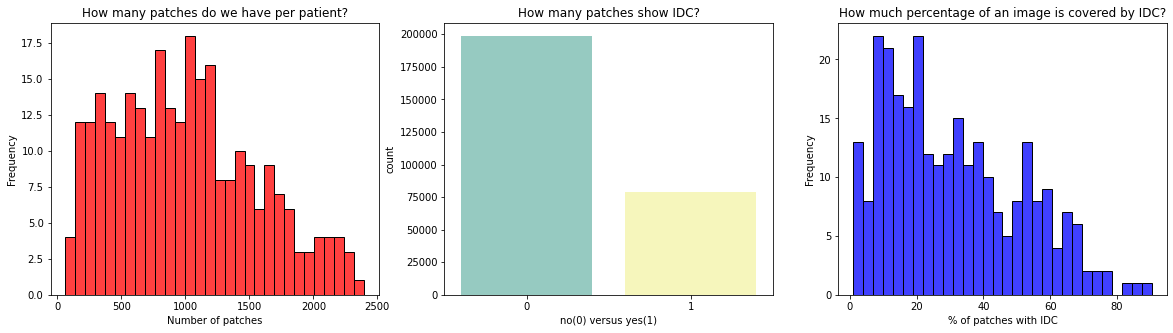

In [12]:
cancer_perc = df.groupby("patient_ID").IDC.value_counts()/ df.groupby("patient_ID").IDC.size()
cancer_perc = cancer_perc.unstack()

fig, ax = plt.subplots(1,3,figsize=(20,5))
sns.histplot(df.groupby("patient_ID").size(), ax=ax[0], color="red", kde=False, bins=30)
ax[0].set_xlabel("Number of patches")
ax[0].set_ylabel("Frequency");
ax[0].set_title("How many patches do we have per patient?");
sns.countplot(df.IDC, palette="Set3", ax=ax[1]);
ax[1].set_xlabel("no(0) versus yes(1)")
ax[1].set_title("How many patches show IDC?");
sns.histplot(cancer_perc.loc[:, 1]*100, ax=ax[2], color="blue", kde=False, bins=30)
ax[2].set_title("How much percentage of an image is covered by IDC?")
ax[2].set_ylabel("Frequency")
ax[2].set_xlabel("% of patches with IDC");

OK, so pretty good range of patch counts per patient, looks like some patches are over 80% IDC tumors, and the majority of patches don't contain IDC tumors. Let's look at what these patches actually look like!

In [13]:
#First we'll randomly select 25 patches of both IDC positive and negative images:
df.IDC = df.IDC.astype(np.int)

pos_selection = np.random.choice(df[df.IDC==1].index.values, size=25, replace=False)
neg_selection = np.random.choice(df[df.IDC==0].index.values, size=25, replace=False)

Next we'll build some subplots to show the randomly selected slides

Positive

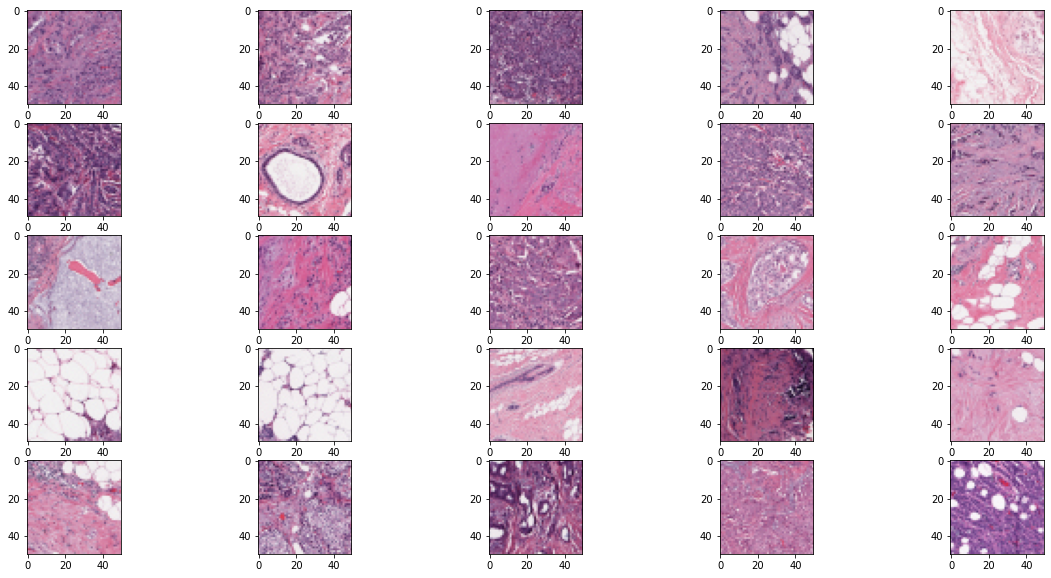

In [14]:
#Next we'll build some subplots to show those randomly selected slides

fig, ax = plt.subplots(5,5,figsize=(20,10))

for n in range(5):
    for m in range(5):
        idx = pos_selection[m + 5*n]
        image = imread(df.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

Negative

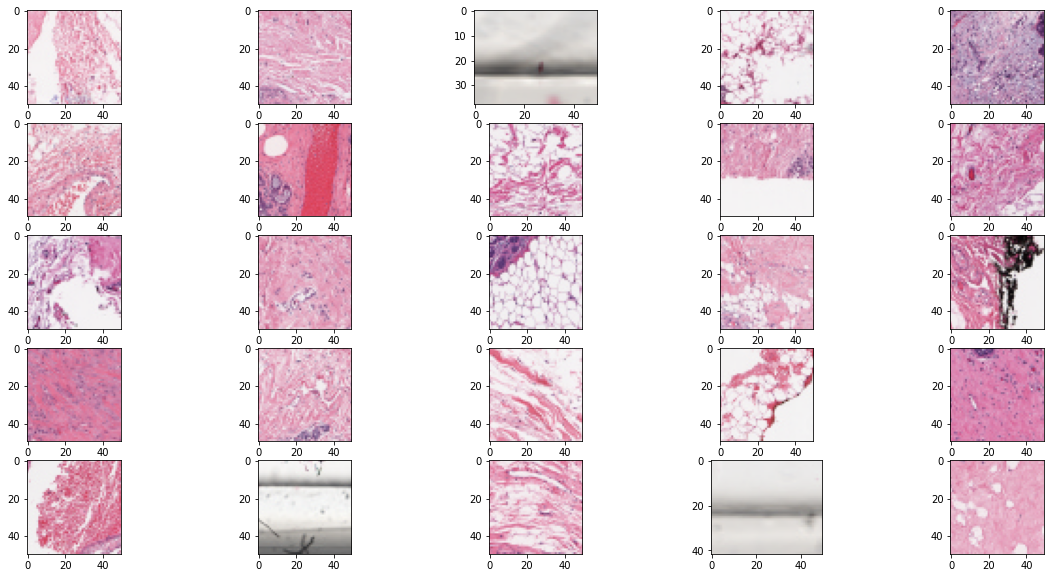

In [15]:
fig, ax = plt.subplots(5,5,figsize=(20,10))

for n in range(5):
    for m in range(5):
        idx = neg_selection[m + 5*n]
        image = imread(df.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

Next lets adjust the pixel values of each image to be between 0 and 1, this will help for standardizing images before we start training models.

In [16]:
#first load all images and resize them to standard sizes

resized_image =[]
images = glob(r'C:/Users/benja/Dropbox/Ben Code/Springboard not GIT linked/IDC_image_data/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive=True)
for img in images:
        full_size_image = cv2.imread(img)
        resized_image.append(cv2.resize(full_size_image, (50,50), interpolation=cv2.INTER_CUBIC))

In [17]:
#Next we're going to convert the pixel values to be between 0 and 1 for faster processing later on - most pixel values are between 0 and 255 so we'll just divide them by 255
scaled_image = np.array(resized_image) #create an array of pixel values for each image from resized_image
scaled_image = scaled_image/255 #scale the pixel values to be between 0 and 1 for faster analysis
print(np.max(scaled_image[0])) #check images for any values over 1

0.9882352941176471


In [18]:
print('class0.png' in scaled_image)
print('class1.png' in scaled_image)

False
False


C:\Users\benja\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """Entry point for launching an IPython kernel.
C:\Users\benja\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


### Begin EDA

We're going to start our exploratory data analysis by creating a binary visualization of our images of tissue samples, then reconstruct some of the full tissue images.

In [19]:
def get_cancer_dataframe(patient_id, cancer_id):
    path = base_path + patient_id + "/" + cancer_id
    files = os.listdir(path)
    dataframe = pd.DataFrame(files, columns=["filename"])
    path_names = path + "/" + dataframe.filename.values
    dataframe = dataframe.filename.str.rsplit("_", n=4, expand=True)
    dataframe.loc[:, "target"] = np.int(cancer_id)
    dataframe.loc[:, "path"] = path_names
    dataframe = dataframe.drop([0, 1, 4], axis=1)
    dataframe = dataframe.rename({2: "x", 3: "y"}, axis=1)
    dataframe.loc[:, "x"] = dataframe.loc[:,"x"].str.replace("x", "", case=False).astype(np.int)
    dataframe.loc[:, "y"] = dataframe.loc[:,"y"].str.replace("y", "", case=False).astype(np.int)
    return dataframe

def get_patient_dataframe(patient_ID):
    df_0 = get_cancer_dataframe(patient_ID, "0")
    df_1 = get_cancer_dataframe(patient_ID, "1")
    patient_df = df_0.append(df_1)
    return patient_df

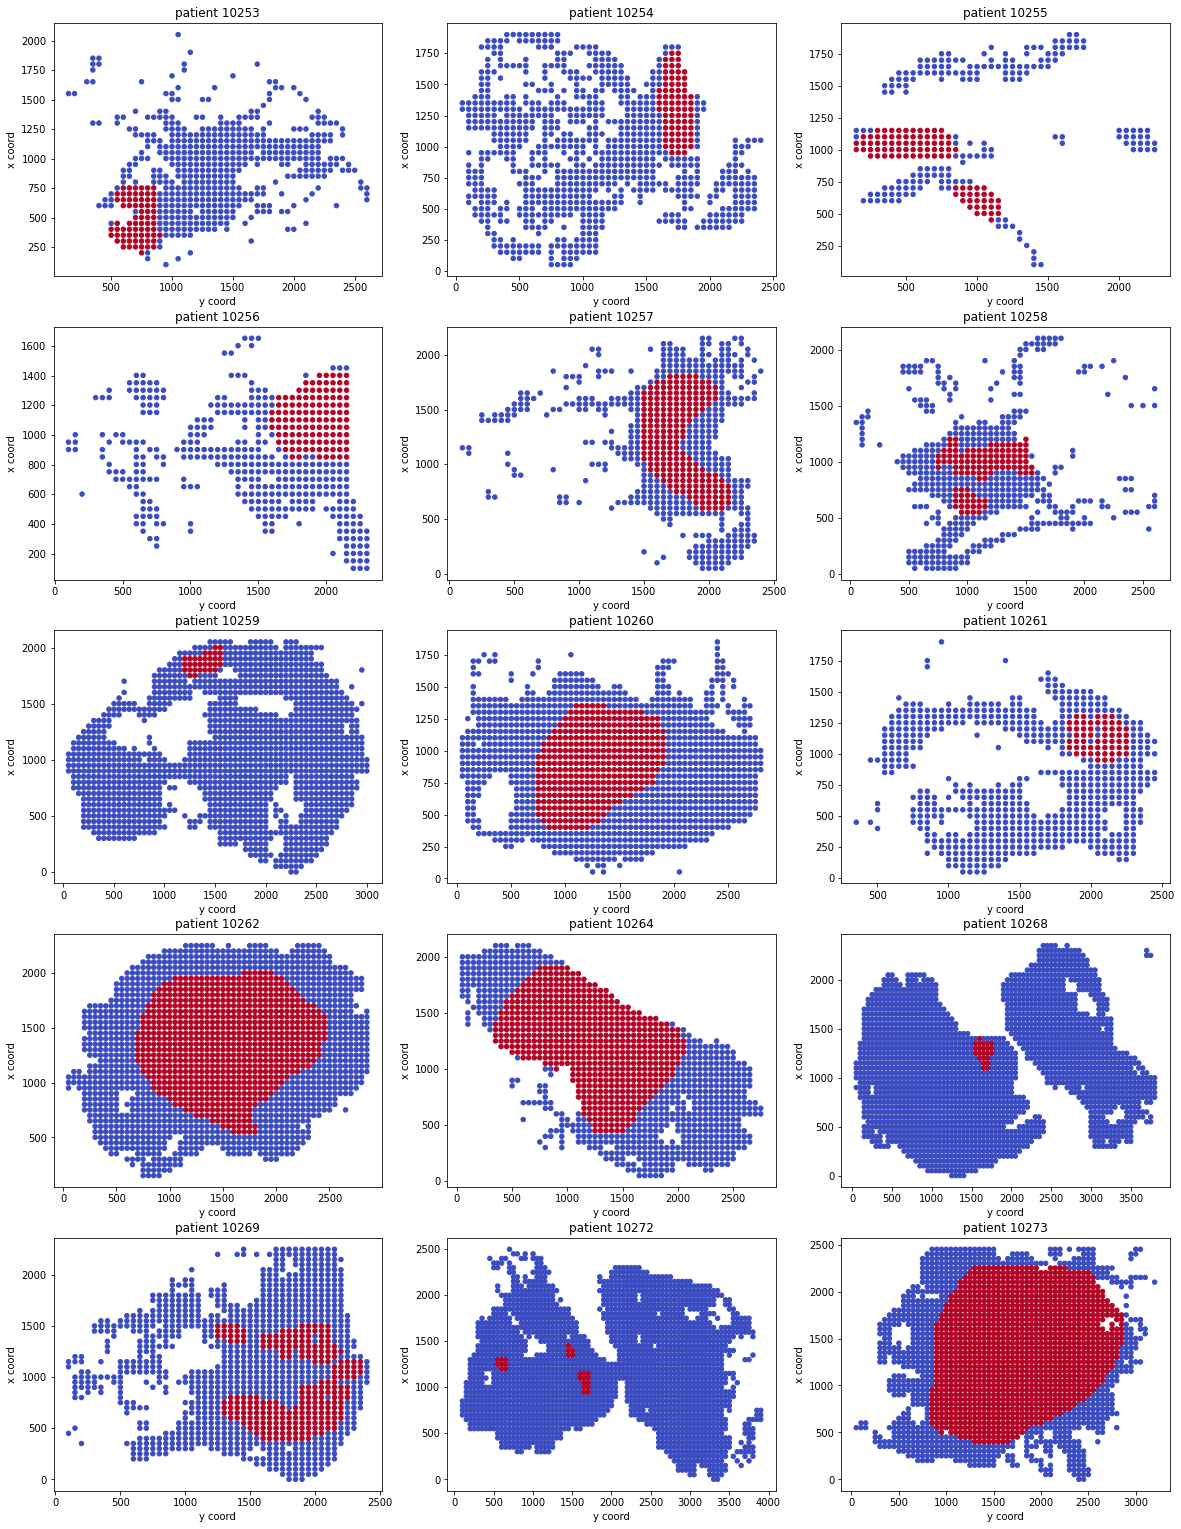

In [20]:
fig, ax = plt.subplots(5,3,figsize=(20, 27))

patient_ids = df.patient_ID.unique()

for n in range(5):
    for m in range(3):
        patient_id = patient_ids[m + 3*n]
        example_df = get_patient_dataframe(patient_id)
        
        ax[n,m].scatter(example_df.x.values, example_df.y.values, c=example_df.target.values, cmap="coolwarm", s=20);
        ax[n,m].set_title("patient " + patient_id)
        ax[n,m].set_xlabel("y coord")
        ax[n,m].set_ylabel("x coord")

The above images show full tissue samples of patients, and there are a two main take-aways here. First, the red dots are slices that contain cancerous cells, while blue dots do not. Second, we can see that for some of these we have incomplete tissue sample images. This should not impact our goal of creating an effective CNN to detect cancerous cells from tissue sample images, but it is worth noting that in a way we're working with an incomplete data set.

Next let's visualize a full tissue sample of a patient. 

In [21]:
def visualise_breast_tissue(patient_id, pred_df=None):
    example_df = get_patient_dataframe(patient_id)
    max_point = [example_df.y.max()-1, example_df.x.max()-1]
    grid = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    mask = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    if pred_df is not None:
        patient_df = pred_df[pred_df.patient_id == patient_id].copy()
    mask_proba = np.zeros(shape = (max_point[0] + 50, max_point[1] + 50, 1)).astype(np.float)
    
    broken_patches = []
    for n in range(len(example_df)):
        try:
            image = imread(example_df.path.values[n])
            
            target = example_df.target.values[n]
            
            x_coord = np.int(example_df.x.values[n])
            y_coord = np.int(example_df.y.values[n])
            x_start = x_coord - 1
            y_start = y_coord - 1
            x_end = x_start + 50
            y_end = y_start + 50

            grid[y_start:y_end, x_start:x_end] = image
            if target == 1:
                mask[y_start:y_end, x_start:x_end, 0] = 250
                mask[y_start:y_end, x_start:x_end, 1] = 0
                mask[y_start:y_end, x_start:x_end, 2] = 0
            if pred_df is not None:
                
                proba = patient_df[
                    (patient_df.x==x_coord) & (patient_df.y==y_coord)].proba
                mask_proba[y_start:y_end, x_start:x_end, 0] = np.float(proba)

        except ValueError:
            broken_patches.append(example_df.path.values[n])
    
    
    return grid, mask, broken_patches, mask_proba

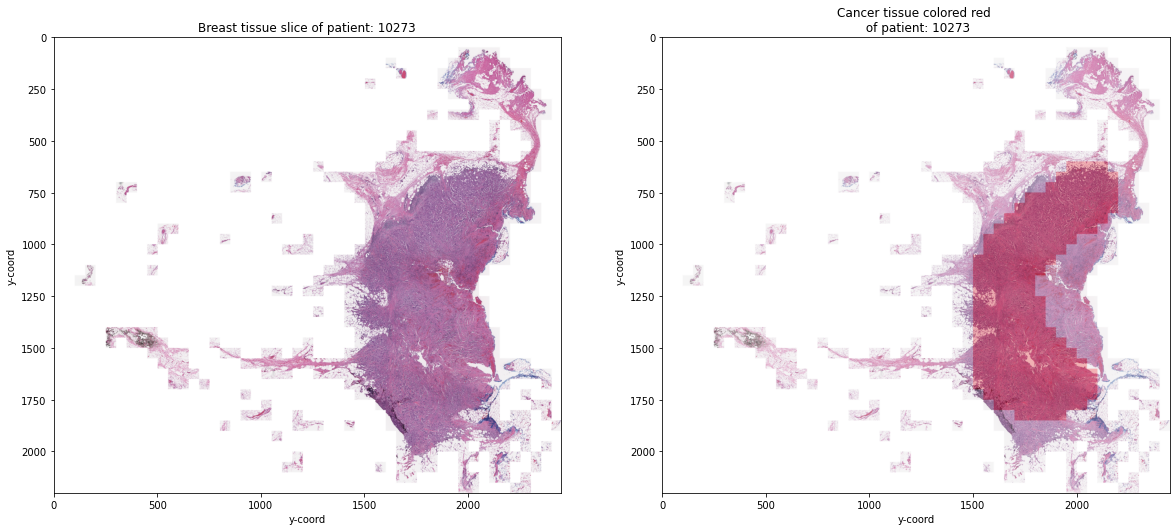

In [22]:
#Lets run an example on patient 10257

example = "10257"
grid, mask, broken_patches,_ = visualise_breast_tissue(example)

fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(grid, alpha=0.9)
ax[1].imshow(mask, alpha=0.8)
ax[1].imshow(grid, alpha=0.7)
ax[0].grid(False)
ax[1].grid(False)
for m in range(2):
    ax[m].set_xlabel("y-coord")
    ax[m].set_ylabel("y-coord")
ax[0].set_title("Breast tissue slice of patient: " + patient_id)
ax[1].set_title("Cancer tissue colored red \n of patient: " + patient_id);

The above images show the same sample reconstructed from our partial images provided. The image on the left is the "raw" image, unaltered and simply assembled. The image on the right, however has cancerous regions coded in red. It's difficult to discern any pattern here, apart from cancer seems to only appear in purple-hued regions. Perhaps these contain a higher concentration of mammary ducts? Additionally, I chose this patient to reitterate and better illustrate that we don't have complete images for all patients. These assembled images show clearly the kinds of data we're working with here. Again, this shouldn't impact our CNN, but it is something to be aware of.

## Prep data for Convolutional Neural Network

We'll split the data into two groups, training and testing along an 80/20 split.

Due to the imbalance of our data set (we have almost 3 times as many non-cancerous images) we will assign class weights with tensorflow to correct for this rather than reducing our data set.
We will use flow from dataframe in tensorflow to match the IDC positive and negative values held in the IDC column of our dataframe - note we could also reference class 1 and class 0 values in our image IDs.

In [23]:
#Split the data into 80/20 train/test
from sklearn.model_selection import train_test_split

y = df['IDC']

X_train, X_test = train_test_split(df['image_ID'], test_size = 0.2, random_state = 42)

print(X_train.head())

92758       12898_idx5_x651_y151_class0.png
233995     9125_idx5_x1351_y1401_class1.png
196679      8863_idx5_x1651_y901_class0.png
177928    15902_idx5_x2551_y1501_class1.png
169919     15513_idx5_x1001_y651_class0.png
Name: image_ID, dtype: object
